<a href="https://colab.research.google.com/github/matiwertyl2/nn_project/blob/master/NNProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q torch torchvision
!pip install -q pillow==4.1.1

fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.0 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.0 which is incompatible.


In [0]:
# Common imports

%pylab inline

import torch

import numpy as np

import PIL
from PIL import Image
import os

from matplotlib import patches

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    import common.plotting

Populating the interactive namespace from numpy and matplotlib


In [0]:
CUDA = True

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return torch.tensor(x, **kwargs)

# Stanford Dogs Dataset

In [0]:
class SubsampledImageDataset(Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [0]:
# fetch the data
![ -e images.tar ] || wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
![ -d Images ] || tar xf images.tar

In [0]:
dogs_whole_dataset = torchvision.datasets.ImageFolder('./Images/')
idx_to_label = dogs_whole_dataset.classes

all_indexes = np.random.permutation(len(dogs_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

dogs_train_dataset = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(299),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ]))

def noise(x):
    return x + 0.04*torch.randn_like(x)

dogs_train_aug = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.RandomAffine(8, (0.08, 0.08), (0.85, 1)),
        torchvision.transforms.RandomResizedCrop(299),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(noise)
    ]))

dogs_test_dataset = SubsampledImageDataset(
    dogs_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(299),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.ToTensor()
    ]))


dogs_datasets = {
    'train': dogs_train_dataset,
    'test': dogs_test_dataset,
    'aug': dogs_train_aug
}

In [0]:
batch_size = 64

dogs_loaders = {
    'train': torch.utils.data.DataLoader(
        dogs_datasets['train'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'aug': torch.utils.data.DataLoader(
        dogs_datasets['aug'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        dogs_datasets['test'], batch_size=batch_size,
        num_workers=4,
        shuffle=False)}

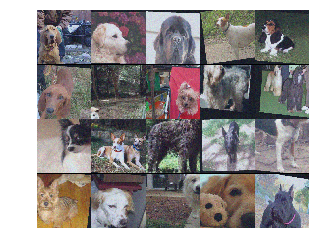

In [0]:
train_batch = next(iter(dogs_loaders['aug']))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


n02109525-Saint_Bernard


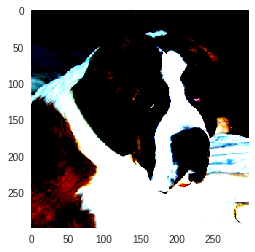

In [0]:
x,y = dogs_train_dataset[5]
print(idx_to_label[y])
plt.imshow(to_np(x.permute(1, 2, 0)))
plt.grid(False)

# Our Dataset

In [0]:
# fetch the data
![ -e data.tar.gz ] || wget https://github.com/matiwertyl2/nn_project/raw/master/data.tar.gz
![ -e yolo_metadata.npy ] || wget https://github.com/matiwertyl2/nn_project/raw/master/yolo_metadata.npy
![ -d data ] || tar zxf data.tar.gz

In [0]:
class DogsDetectionDataset(Dataset):
    
    def __init__(self, meta_file, root_dir, imsize=224):
        self.meta = np.load(meta_file).astype(np.float32)
        self.root = root_dir
        self.imsize = imsize
        
    def __len__(self):
        return self.meta.shape[0]
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(idx) + '.jpg')
        image = Image.open(img_name)
        image = image.resize((self.imsize, self.imsize), PIL.Image.ANTIALIAS)
            
        torch_img = torch.from_numpy(numpy.array(image, dtype=np.float32))
        torch_meta = torch.from_numpy(self.meta[idx])
        return (torch_img, torch_meta)

In [0]:
def batch_label_to_bbox(label):
    grid = label.shape[1]
    stride = 1.0 / float(grid)
    
    label = label.view(label.shape[0], -1, 5)
    conf = label[:, :, 4]

    best = torch.argmax(conf, dim=1)
    pred = []
    for i in range(label.shape[0]):
        b = best[i]
        x, y = b % grid, b / grid
        coords = label[i, b, :]
        
        box_x, box_y = stride * (x+coords[0]), stride * (y+coords[1])
        box_w, box_h = coords[2]*coords[2], coords[3]*coords[3]
        
        pred.append(torch.FloatTensor([box_x, box_y, box_w, box_h]))
            
    return torch.cat(pred)
                    
def show_image_bbox(img, meta):
    img = img.astype(int)
    imsize = img.shape[0]
    x, y, w, h = imsize * batch_label_to_bbox(torch.from_numpy(meta).unsqueeze(0))
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    ax.grid(False)

    # Create a Rectangle patch
    rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

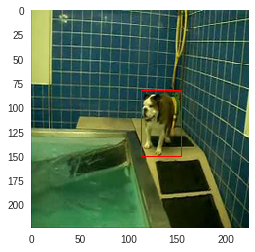

In [0]:
dogs_dataset = DogsDetectionDataset('./yolo_metadata.npy', './raw')

x, y = dogs_dataset[0]
show_image_bbox(x.numpy(), y.numpy())

In [0]:
class SubsampledImageDataset(Dataset):
    def __init__(self, dataset, indexes, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [0]:
all_indexes = np.random.permutation(len(dogs_dataset))
train_size = int(len(all_indexes) * 0.8)

dogs_train_dataset = SubsampledImageDataset(
    dogs_dataset,
    all_indexes[:train_size])

dogs_test_dataset = SubsampledImageDataset(
    dogs_dataset,
    all_indexes[train_size:])


dogs_datasets = {
    'train': dogs_train_dataset,
    'test': dogs_test_dataset,
}

In [0]:
batch_size = 64

dogs_loaders = {
    'train': torch.utils.data.DataLoader(
        dogs_datasets['train'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        dogs_datasets['test'], batch_size=batch_size,
        num_workers=4,
        shuffle=False)}

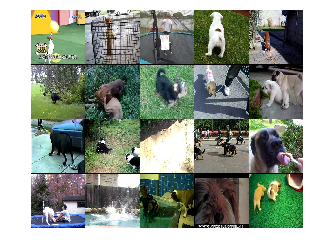

In [0]:
train_batch = next(iter(dogs_loaders['test']))
common.plotting.plot_mat(to_np(train_batch[0].permute(0, 3, 1, 2))[:20])

In [0]:
def batch_change_repr(batch):
    mid_xy = batch[:, :2]
    wh = batch[:, 2:4]
    topleft_xy = mid_xy - wh/2
    bottomright_xy = mid_xy + wh/2
    return torch.cat((topleft_xy, bottomright_xy), 1)

def batch_iou(pred, truth):
    pred_xy = batch_change_repr(pred)
    truth_xy = batch_change_repr(truth)
    both_xy = torch.stack((pred_xy, both_xy), 2)
    topleft_xy = torch.max(both_xy[:, :, :2], 2)
    bottomright_xy = torch.max(both_xy[:, :, 2:], 2)
    pred_left

# VGG Based YOLO

In [0]:
class VGGPreprocess(nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x

In [0]:
VGG_out_features = 25088

def select_indices(input, indices):
    # output[i, j, k, l] = input[i, j, k, indices[i, j, k], l]
    new_shape = (input.shape[0], input.shape[1], input.shape[2], input.shape[4])
    output = np.fromfunction(lambda i, j, k, l : 
        input[np.array(i, dtype=int), np.array(j, dtype=int), np.array(k, dtype=int), 
            indices[np.array(i, dtype=int), np.array(j, dtype=int), np.array(k, dtype=int)],
            np.array(l, dtype=int)], new_shape)
    return output

class VGGYolo(nn.Module):
    
    def __init__(self, grid=7, boxes=2, intermediate=4096):
        super(VGGYolo, self).__init__()
#         self.classes = classes
        self.grid = grid
        self.boxes = boxes
        
        self.preprocess = VGGPreprocess()
        
        vgg = torchvision.models.vgg16(pretrained=True)
        self.features = vgg.features
        for p in self.features.parameters():
            p.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(VGG_out_features, intermediate),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(intermediate, grid*grid*5*boxes)
#             nn.Linear(intermediate, grid*grid*(5*boxes+classes))
        )
        
        self.coord = 5.0
        self.noobj = 0.5
#         self.I = torch.eye(self.classes)
        
#     def int_to_onehot(self, x):
#         shape = x.shape
#         shape += (-1,)
#         return (self.I[x.flatten()]).reshape(shape)
        
    def get_responsible(out):
        boxes = out.view(out.size(0), self.grid, self.grid, self.boxes, -1)
        conf = boxes[:, :, :, :, 4]
        
        resp = torch.argmax(conf, dim=3)
        return select_indices(boxes, resp)
    
    def forward(self, x):
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), self.grid, self.grid, -1)
        return x
        
    def loss(self, out, y):
#         boxes = out[:, :, :, :5*self.boxes]

        resp = self.get_responsible(out)
        resp_coords = resp_boxes[:, :, :, :4]
        resp_conf = resp_boxes[:, :, :, 4]
        
        y_coords = y[:, :, :, :4]
        y_conf = y[:, :, :, 4]
        
        L = self.coord*torch.sum(y_conf.unsqueeze(3)*torch.pow(resp_coords-y_coords, 2))
        L += torch.sum((y_conf+(1-y_conf)*self.noobj)*torch.pow(resp_conf-y_conf, 2))
        
#         classes = out[:, :, :, 5*self.boxes:]
#         y_class = y[:, :, :, 5].squeeze()
#         y_onehot = self.int_to_onehot(y_class)
        
#         L += y_conf * torch.pow(classes-y_onehot, 2)
                    
        return L
    
    def predict(self, x):
        out = self.forward(x)
        resp = self.get_responsible(out)
        
        return batch_label_to_bbox(resp)

In [0]:
yolo = VGGYolo(grid=24)
x, y = next(iter(dogs_loaders['train']))
yolo.cuda()
x.cuda()
y.cuda()
out = yolo.forward(x)
loss = yolo.loss(out, y)

# Training YOLO

In [0]:
# Training code is based on assignment 4
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    iou_sum = 0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():
            real_boxes = batch_label_to_bbox(y)
            pred_boxes = model.predict(x)
            iou_sum += batch_iou(real_boxes, pred_boxes)
            num_examples += x.size(0)
    return 100.0 * (1.0 - iou_sum / num_examples)

        
def train(model, data_loaders, train_loader, optimizer, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders[train_loader]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                
                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate.item())

                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.item(), err_rate)

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()        

In [0]:
criterion = nn.CrossEntropyLoss()

# Train only the params of the classifier
optimizer = torch.optim.Adam(
    inception.fc.parameters(), lr=0.0001)

train(inception, dogs_loaders, 'aug', optimizer,
      num_epochs=10, log_every=50, cuda=True)